
# Logistic Regression with Python

we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this  notebook.

## Import Libraries
Let's import some libraries to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

# Select most valueable columns with RFE
from sklearn.feature_selection import RFE
import statsmodels.api as sm

# Grid search cross validation
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
train = pd.read_csv('titanic_train.csv')
train_for_last_question = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

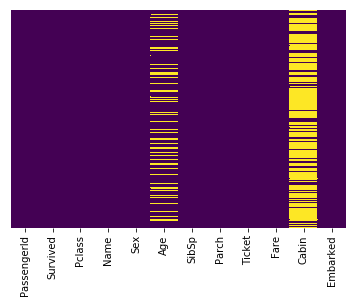

In [3]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! 

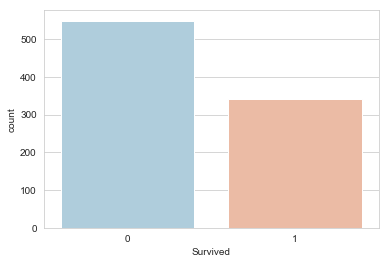

In [4]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

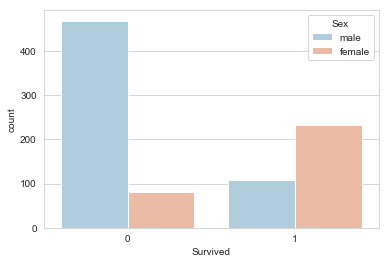

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

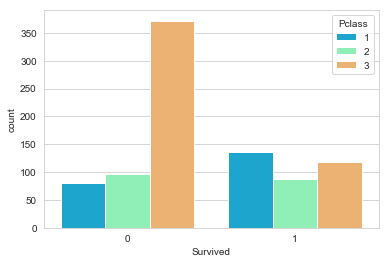

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

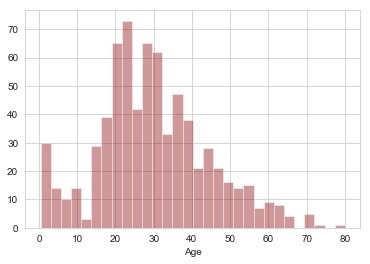

In [7]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

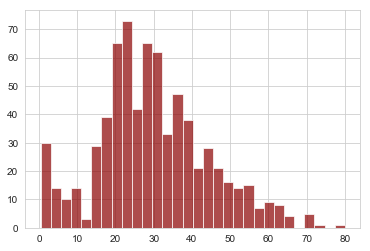

In [8]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

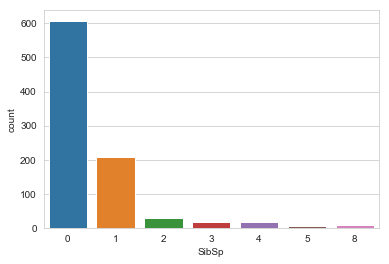

In [9]:
sns.countplot(x='SibSp',data=train)

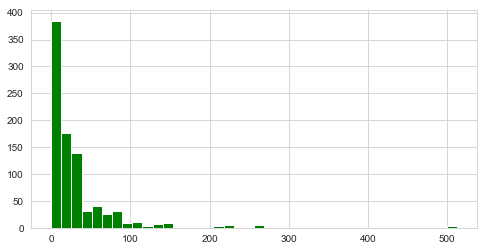

In [10]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


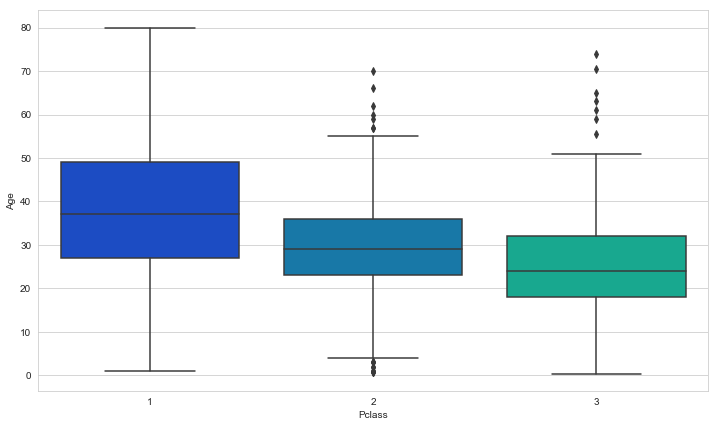

In [11]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [12]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [13]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

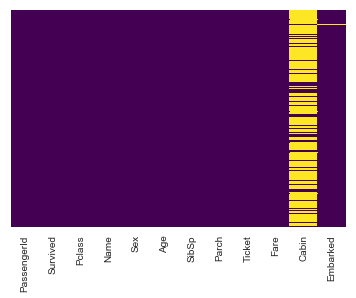

In [14]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [15]:
train.drop('Cabin',axis=1,inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [16]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [18]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [19]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [20]:
train = pd.concat([train,sex,embark],axis=1)

In [21]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [27]:
from sklearn.metrics import classification_report

In [28]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       163
           1       0.85      0.65      0.74       104

   micro avg       0.82      0.82      0.82       267
   macro avg       0.83      0.79      0.80       267
weighted avg       0.82      0.82      0.81       267



Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?



# PELIN GUNDOGDU

### Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature

In [29]:
train_for_last_question[("Title")]=(train_for_last_question.Name.str.split(",",expand = True, n=1)[1].str.split(".",expand = True)[0])
train_for_last_question.groupby(["Sex","Title"]).size()

Sex     Title        
female   Dr                1
         Lady              1
         Miss            182
         Mlle              2
         Mme               1
         Mrs             125
         Ms                1
         the Countess      1
male     Capt              1
         Col               2
         Don               1
         Dr                6
         Jonkheer          1
         Major             2
         Master           40
         Mr              517
         Rev               6
         Sir               1
dtype: int64

### Female
* Mademoiselle -> Mlle
* Madame -> Mme

### Male
* Colonel -> Col
* Jonkheer -> Prefix for male

It seems that "Title" and "Gender" show same reality. I prefer to use "Sex" column instead of "Title". 
Because in "Title" columns there are lots of option but in "Sex" column there are only two options as "female" and "male.

### Maybe the Cabin letter could be a feature
    
    The "Cabin" feature has lots of missing data. It is better not to consider

### Is there any info you can get from the ticket?

    In "Ticket" feature there is no pattern to clarify.

In [30]:
train_for_last_question["Ticket"].value_counts()

CA. 2343             7
1601                 7
347082               7
3101295              6
CA 2144              6
347088               6
382652               5
S.O.C. 14879         5
LINE                 4
PC 17757             4
19950                4
4133                 4
2666                 4
113760               4
17421                4
W./C. 6608           4
347077               4
349909               4
113781               4
248727               3
347742               3
PC 17755             3
110152               3
C.A. 34651           3
F.C.C. 13529         3
SC/Paris 2123        3
110413               3
239853               3
PC 17582             3
35273                3
                    ..
2700                 1
2689                 1
112379               1
C.A. 34260           1
A/5 21174            1
28228                1
312991               1
110564               1
345770               1
350036               1
STON/O 2. 3101275    1
350029               1
27849      

In [31]:
# Before starting the analyze, I want to see the result with "class_weight".
# Because of the number of non-survived is double of the number survived, I penalize survived class double times.
lr_with_CW = LogisticRegression(class_weight={1:0.2, 0:0.1})
lr_with_CW.fit(X_train,y_train)
predictions_with_CW = lr_with_CW.predict(X_test)
print(classification_report(y_test,predictions_with_CW))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       163
           1       0.74      0.73      0.73       104

   micro avg       0.79      0.79      0.79       267
   macro avg       0.78      0.78      0.78       267
weighted avg       0.79      0.79      0.79       267



This penalization shows a little bit improvement in recall.

## ANALYZE

In [32]:
titanic_train = pd.read_csv('titanic_train.csv', index_col="PassengerId")
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


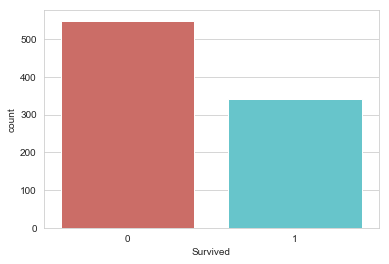

In [34]:
sns.countplot(x=titanic_train.Survived, palette="hls")
plt.savefig("images/00_Count_survived")

In [35]:
survived_0 = titanic_train.Survived.value_counts()[0] / len(titanic_train.Survived)
survived_1 = titanic_train.Survived.value_counts()[1] / len(titanic_train.Survived)
print("Survived percentage;\nsurvived: {:.2f}\nnot survived: {:.2f}".format(survived_1, survived_0))

Survived percentage;
survived: 0.38
not survived: 0.62


#### It seems our target value is imbalanced.

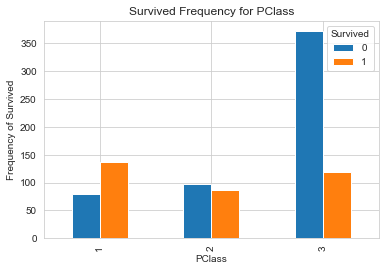

In [36]:
pd.crosstab(titanic_train.Pclass, titanic_train.Survived).plot(kind='bar')
plt.title("Survived Frequency for PClass")
plt.xlabel("PClass")
plt.ylabel("Frequency of Survived")
plt.savefig("images/01_pclass_survived_freq")

The "PClass" can be a good predictor

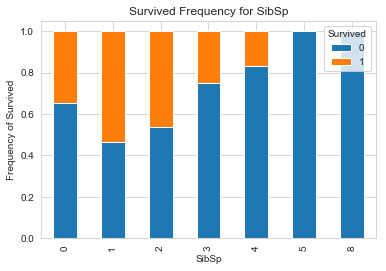

In [37]:
table=pd.crosstab(titanic_train.SibSp, titanic_train.Survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title("Survived Frequency for SibSp")
plt.xlabel("SibSp")
plt.ylabel("Frequency of Survived")
plt.savefig("images/02_SibSp_survived_freq")

The "SibSp" can not be a good predictor. It seems that there is no survived more than 4 "SibSp".

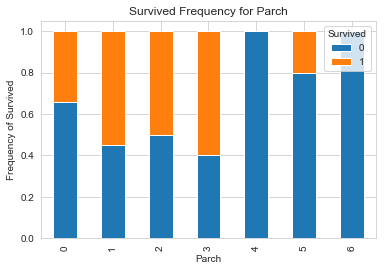

In [38]:
table=pd.crosstab(titanic_train.Parch, titanic_train.Survived)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title("Survived Frequency for Parch")
plt.xlabel("Parch")
plt.ylabel("Frequency of Survived")
plt.savefig("images/03_Parch_survived_freq")

The "Parch" can not be a good predictor. It seems that for 4 and 6, there are no survived.

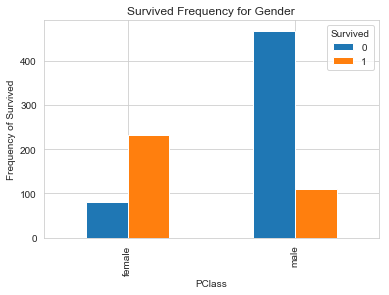

In [39]:
pd.crosstab(titanic_train.Sex, titanic_train.Survived).plot(kind='bar')
plt.title("Survived Frequency for Gender")
plt.xlabel("PClass")
plt.ylabel("Frequency of Survived")
plt.savefig("images/04_gender_survived_freq")

The "Sex" can be a good predictor.

## AGE missing data

### KNN algorithm to fill the missing values in "Age" column

In [40]:
age_range_width = int( (max(titanic_train["Age"])+1 - min(titanic_train["Age"])) / 5 )
bins_range = range( int(min(titanic_train["Age"])), int(max(titanic_train["Age"]))+1, age_range_width )
age_group_names = []
for i in bins_range:
    if i != bins_range[-1]:
        if i+1 == 1:
            i = 0
        names = str(i) + "-" + str(i+age_range_width)
        age_group_names.append(names)
    
titanic_train["age_group"] = pd.cut(titanic_train["Age"], bins=bins_range, labels=age_group_names)

In [41]:
len(titanic_train.loc[titanic_train.Age.isna() == True])

177

In [42]:
knn_age_na = titanic_train.loc[titanic_train.Age.isna() == True]
knn_age = titanic_train.loc[titanic_train.Age.isna() == False]
#print(knn_age.get_dtype_counts())
knn_age.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_group
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,16-32
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,32-48
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,16-32
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,32-48
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,32-48


In [43]:
col_knn = ["Pclass", "Sex", "Embarked", "age_group"]
knn_age = knn_age[col_knn]
knn_age = knn_age.join(
            pd.get_dummies(data=knn_age["Sex"], drop_first=True)).join(
            pd.get_dummies(data=knn_age["Embarked"], prefix="embarked")).join(
            pd.get_dummies(data=knn_age["Pclass"], prefix="class"))
knn_age.drop(columns=["Sex", "Embarked", "Pclass"], inplace=True)
knn_age.head()

,age_group,male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3
PassengerId,,,,,,,,
1,16-32,1,0,0,1,0,0,1
2,32-48,0,1,0,0,1,0,0
3,16-32,0,0,0,1,0,0,1
4,32-48,0,0,0,1,1,0,0
5,32-48,1,0,0,1,0,0,1


In [44]:
knn_age.astype(str).groupby("age_group").groups.keys()

dict_keys(['0-16', '16-32', '32-48', '48-64', '64-80'])

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix  

knn_age_X = knn_age.loc[:, knn_age.columns != "age_group"]  
knn_age_y = knn_age.loc[:, knn_age.columns == "age_group"]  

knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(knn_age_X, knn_age_y, test_size=0.2, random_state = 0)

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(knn_X_train, knn_y_train)

y_pred = classifier.predict(knn_X_test)
print(confusion_matrix(knn_y_test, y_pred))  
print(classification_report(knn_y_test, y_pred))  

[[10  6  1  2  0]
 [25 26  8  6  0]
 [11 13 11  7  0]
 [ 1  8  4  2  0]
 [ 0  0  2  0  0]]
              precision    recall  f1-score   support

        0-16       0.21      0.53      0.30        19
       16-32       0.49      0.40      0.44        65
       32-48       0.42      0.26      0.32        42
       48-64       0.12      0.13      0.12        15
       64-80       0.00      0.00      0.00         2

   micro avg       0.34      0.34      0.34       143
   macro avg       0.25      0.26      0.24       143
weighted avg       0.39      0.34      0.35       143



In [46]:
knn_age_na = knn_age_na[col_knn]
knn_age_na = knn_age_na.join(
            pd.get_dummies(data=knn_age_na["Sex"], drop_first=True)).join(
            pd.get_dummies(data=knn_age_na["Embarked"], prefix="embarked")).join(
            pd.get_dummies(data=knn_age_na["Pclass"], prefix="class"))
knn_age_na.drop(columns=["Sex", "Embarked", "Pclass"], inplace=True)
knn_age_na.head()

,age_group,male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3
PassengerId,,,,,,,,
6,NaN,1,0,1,0,0,0,1
18,NaN,1,0,0,1,0,1,0
20,NaN,0,1,0,0,0,0,1
27,NaN,1,1,0,0,0,0,1
29,NaN,0,0,1,0,0,0,1


In [47]:
knn_age_na.loc[:, knn_age_na.columns == "age_group"] = classifier.predict(knn_age_na.loc[:, knn_age_na.columns != "age_group"]  )
knn_age_na.head()

,age_group,male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3
PassengerId,,,,,,,,
6,16-32,1,0,1,0,0,0,1
18,16-32,1,0,0,1,0,1,0
20,0-16,0,1,0,0,0,0,1
27,16-32,1,1,0,0,0,0,1
29,16-32,0,0,1,0,0,0,1


In [48]:
titanic_train.loc[ (titanic_train.age_group.isnull() == True), "age_group"] = knn_age_na["age_group"]

In [49]:
len(titanic_train.loc[titanic_train.age_group.isna() == True])

0

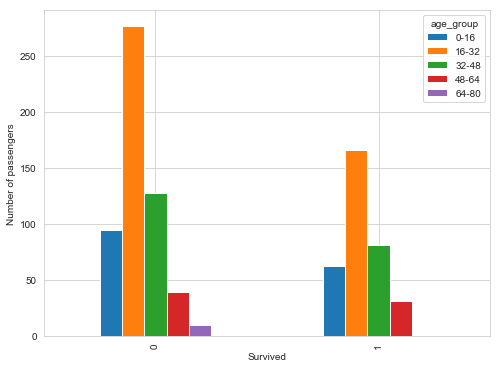

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
df_age_survived = titanic_train.groupby(["age_group","Survived"])["Pclass"].count().to_frame().pivot_table(columns="age_group", index="Survived", values="Pclass")
df_age_survived.plot(kind="bar", ax=ax)
plt.ylabel("Number of passengers");

The "Age" can be a good predictor.

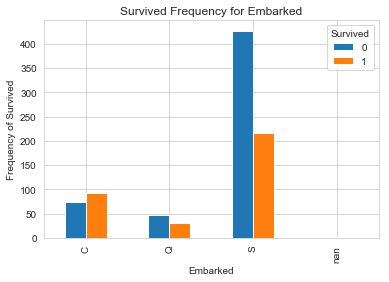

In [51]:
pd.crosstab(titanic_train.astype(str).Embarked, titanic_train.Survived).plot(kind='bar')
plt.title("Survived Frequency for Embarked")
plt.xlabel("Embarked")
plt.ylabel("Frequency of Survived")
plt.savefig("images/05_embarked_survived_freq")

The "Embarked" can be a good predictor.

## Handling with missing and categorical data (get_dummies)

In [52]:
titanic_to_use = titanic_train[["Survived", "Pclass", "Sex", "Embarked", "age_group"]]

print("Group of Gender: {},\nGropu of Embarked: {}".format(list(titanic_to_use.astype(str).groupby("Sex").groups.keys())
                                   , list(titanic_to_use.astype(str).groupby("Embarked").groups.keys())))
# as we can see in "Embarked" feature, there are "nan" value. 
# Next step I am going to check how much row seems as "nan".

print("\n")

print("Group of Embarked:\n{}".format(titanic_to_use.astype(str)["Embarked"].value_counts()))

# After checking, I saw only two rows seem "nan". The number of missing data are really small so that,
# I am going to replace the "nan" rows with "S" which is highest number of "Embarked" feature.

Group of Gender: ['female', 'male'],
Gropu of Embarked: ['C', 'Q', 'S', 'nan']


Group of Embarked:
S      644
C      168
Q       77
nan      2
Name: Embarked, dtype: int64


In [53]:
titanic_to_use.loc[titanic_to_use["Embarked"].isna() == True, "Embarked"] = "S"
titanic_to_use.astype(str)["Embarked"].value_counts()
# There are no missing values in "Embarked" feature.

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [54]:
titanic_to_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 5 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null object
Embarked     891 non-null object
age_group    891 non-null category
dtypes: category(1), int64(2), object(2)
memory usage: 75.9+ KB


In [55]:
titanic_corr = titanic_to_use.join(
                    pd.get_dummies(data=titanic_to_use["Sex"], drop_first=True)).join(
                    pd.get_dummies(data=titanic_to_use["age_group"], prefix="age")).join(
                    pd.get_dummies(data=titanic_to_use["Embarked"], prefix="embarked")).join(
                    pd.get_dummies(data=titanic_to_use["Pclass"], prefix="class"))
titanic_corr.drop(columns=["Sex", "age_group", "Embarked", "Pclass"], inplace=True)

titanic_corr.head()

,Survived,male,age_0-16,age_16-32,age_32-48,age_48-64,age_64-80,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3
PassengerId,,,,,,,,,,,,,
1,0,1,0,1,0,0,0,0,0,1,0,0,1
2,1,0,0,0,1,0,0,1,0,0,1,0,0
3,1,0,0,1,0,0,0,0,0,1,0,0,1
4,1,0,0,0,1,0,0,0,0,1,1,0,0
5,0,1,0,0,1,0,0,0,0,1,0,0,1


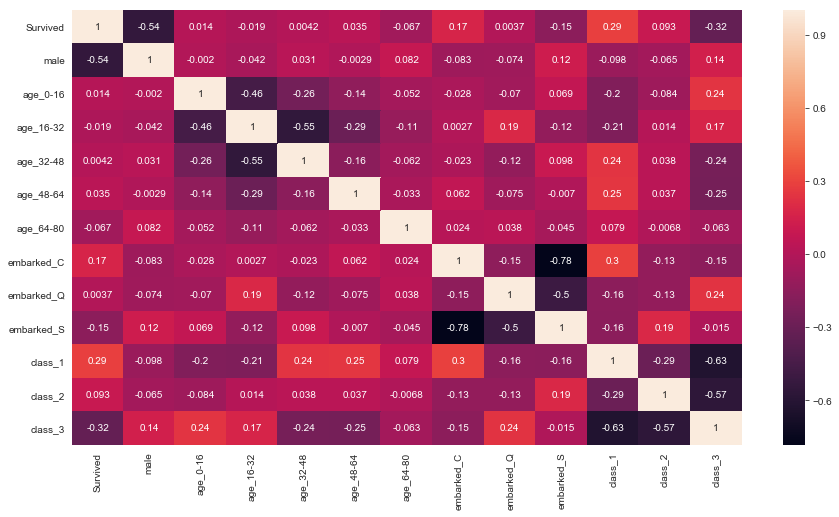

In [56]:
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(titanic_corr.corr(), annot=True);

## Over-sampling using SMOTE

In [57]:
X = titanic_corr.loc[:, titanic_corr.columns != 'Survived']
y = titanic_corr.loc[:, titanic_corr.columns == 'Survived']

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train_smote.columns

#os = SMOTE(random_state=0)
smote_nc = SMOTENC(categorical_features=[0, 1], random_state=0)

os_data_X, os_data_y = smote_nc.fit_sample(X_train_smote, y_train_smote)

#os_data_X, os_data_y = os.fit_sample(X_train_smote, y_train_smote)
os_data_X = pd.DataFrame(data = np.round(os_data_X).astype(int), columns = columns ).astype('category')
os_data_y = pd.DataFrame(data = np.round(os_data_y).astype(int), columns = ['Survived']).astype('category')
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no survived in oversampled data",len(os_data_y[os_data_y['Survived']==0]))
print("Number of survived",len(os_data_y[os_data_y['Survived']==1]))
print("Proportion of no survived data in oversampled data is ",len(os_data_y[os_data_y['Survived']==0])/len(os_data_X))
print("Proportion of survived data in oversampled data is ",len(os_data_y[os_data_y['Survived']==1])/len(os_data_X))

length of oversampled data is  762
Number of no survived in oversampled data 381
Number of survived 381
Proportion of no survived data in oversampled data is  0.5
Proportion of survived data in oversampled data is  0.5


In [58]:
for i in os_data_X.columns:
    print("'{}' - values are {}".format(i, list((os_data_X[i]).value_counts().keys()) ))
    
for i in os_data_y.columns:
    print("'{}' - values are {}".format(i, list((os_data_y[i]).value_counts().keys()) ))

'male' - values are [1, 0]
'age_0-16' - values are [0, 1]
'age_16-32' - values are [0, 1]
'age_32-48' - values are [0, 1]
'age_48-64' - values are [0, 1]
'age_64-80' - values are [0, 1]
'embarked_C' - values are [0, 1]
'embarked_Q' - values are [0, 1]
'embarked_S' - values are [1, 0]
'class_1' - values are [0, 1]
'class_2' - values are [0, 1]
'class_3' - values are [1, 0]
'Survived' - values are [1, 0]


In [59]:
#os_data_X.groupby(["age_0-16", "age_16-32", "age_32-48", "age_48-64", "age_64-80"]).size()
#os_data_X.loc[(os_data_X["age_0-16"] == 0)&(os_data_X["age_16-32"] == 0)&(os_data_X["age_32-48"] == 0)&(os_data_X["age_48-64"] == 0)&(os_data_X["age_64-80"] == 0)]

In [60]:
# sklearn output without intercepct
model = LogisticRegression(fit_intercept = False, C = 1e9)
model.fit(os_data_X, os_data_y)

predictions_smote = model.predict(X_test_smote)
print(classification_report(y_test_smote,predictions_smote))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       168
           1       0.68      0.76      0.72       100

   micro avg       0.78      0.78      0.78       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.79      0.78      0.78       268



In [61]:
# sklearn output with intercepct
model = LogisticRegression(fit_intercept = True, C = 1e9)
model.fit(os_data_X, os_data_y)

predictions_smote = model.predict(X_test_smote)
print(classification_report(y_test_smote,predictions_smote))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       168
           1       0.68      0.76      0.72       100

   micro avg       0.78      0.78      0.78       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.79      0.78      0.78       268



## Recursive Feature Elimination - RFE

In [62]:
logreg = LogisticRegression()
rfe = RFE(logreg, 5)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False False False False False False  True False  True]
[1 1 1 7 5 2 4 6 8 1 3 1]


In [63]:
os_data_X.columns

Index(['male', 'age_0-16', 'age_16-32', 'age_32-48', 'age_48-64', 'age_64-80',
       'embarked_C', 'embarked_Q', 'embarked_S', 'class_1', 'class_2',
       'class_3'],
      dtype='object')

In [64]:
cols = ['male'
        , 'age_0-16'
        , 'age_16-32'
        #, 'age_32-48'
        #, 'age_48-64'
        #, 'age_64-80'
        #, 'embarked_C'
        #, 'embarked_Q'
        #, 'embarked_S'
        , 'class_1'
        #, 'class_2'
        , 'class_3'
]
os_data_X_rfe = os_data_X[cols]
os_data_y_rfe = os_data_y['Survived']
X_test_smote_rfe = X_test_smote[cols]

# sklearn output with intercepct
model = LogisticRegression(fit_intercept = True, C = 1e9)
model.fit(os_data_X_rfe, os_data_y_rfe)

predictions_smote = model.predict(X_test_smote_rfe)
print(classification_report(y_test_smote,predictions_smote))



              precision    recall  f1-score   support

           0       0.85      0.81      0.83       168
           1       0.70      0.76      0.73       100

   micro avg       0.79      0.79      0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.79      0.79       268



## GRID SEARCH

In [65]:
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(os_data_X, os_data_y)
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
# Predict target vector
#best_model.predict(X)

Best Penalty: l1
Best C: 2.7825594022071245


In [66]:
lr_with_GS = LogisticRegression(C=2.7825594022071245, penalty="l1")
lr_with_GS.fit(os_data_X, os_data_y)
predictions_GS = lr_with_GS.predict(X_test_smote)
print(classification_report(y_test_smote, predictions_GS))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       168
           1       0.68      0.76      0.72       100

   micro avg       0.78      0.78      0.78       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.79      0.78      0.78       268



## GRID SEARCH - RFE

In [67]:
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(os_data_X_rfe, os_data_y_rfe)
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
# Predict target vector
#best_model.predict(X)

Best Penalty: l1
Best C: 1.0


In [68]:
lr_with_GS_rfe = LogisticRegression(C=1, penalty="l1")
lr_with_GS_rfe.fit(os_data_X_rfe, os_data_y_rfe)
predictions_GS_rfe = lr_with_GS_rfe.predict(X_test_smote_rfe)
print(classification_report(y_test_smote, predictions_GS_rfe))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       168
           1       0.70      0.76      0.73       100

   micro avg       0.79      0.79      0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.79      0.79       268



## GRID SEARCH with unbalanced data

In [69]:
lr_grid_wo_smote = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
# Create grid search using 5-fold cross validation
clf_wo_smote = GridSearchCV(lr_grid_wo_smote, hyperparameters, cv=5, verbose=0)

best_model_wo_smote = clf_wo_smote.fit(X_train, y_train)
# View best hyperparameters
print('Best Penalty:', best_model_wo_smote.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_wo_smote.best_estimator_.get_params()['C'])
# Predict target vector
#best_model.predict(X)

Best Penalty: l1
Best C: 2.7825594022071245


In [70]:
lr_with_GS_wo_smote = LogisticRegression(C=2.7825594022071245, penalty="l1")
lr_with_GS_wo_smote.fit(X_train, y_train)
predictions_GS_wo_smote = lr_with_GS_wo_smote.predict(X_test)
print(classification_report(y_test, predictions_GS_wo_smote))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       163
           1       0.84      0.68      0.75       104

   micro avg       0.82      0.82      0.82       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.82      0.82       267



In [71]:
from sklearn.metrics import log_loss

log_loss(y_test, predictions_GS_wo_smote)

from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, predictions_GS_wo_smote)  

0.6247354083315644

## Result 

fit_intercept with True anf False options return same measures.

I tried class_weight, RFE and Grid Search techniques to improve the result of algorithm.

I got almost same result with creating new columns (feature engineering) or penalizing.